# This notebook is to reconstruct the following outputs

- CoM - along with a guess of scan rotation and detector flip

- ABF image

- DPC phase reconstruction


```yaml
global_thresholds: 
    value: '0.01, 0.9'
    explanation: 'Provide two values to be sued for lower and upper threshold when detecting the BF disc.'
    prompt: 'thresholds'
remex_hints:
    value: 'standard_science_cluster'
    explanation: 'Hints to the workflow engine regarding cluster processing. Please consult the beamline staff before changing this. Valid choices are: standard_science_cluster, ptypy_mpi, ptyrex_mpi, local'
    prompt: 'remote execution hints'
```

In [1]:
# Leave empty!

In [2]:
%%capture --no-display
%matplotlib notebook
import numpy as np
import h5py
import json
import matplotlib.pyplot as plt
import hyperspy.api as hs
import os
import pyxem as pxm
import logging
import py4DSTEM 

In [ ]:
# This cell to be ignored when running live with bxflow
# dataset name
# data_label = 'cam_length_cal_data/20221130_115151'
# # notebook name
# notebook = 'CoM_DPC_ABF_outputs'
# global_write_json = '0'
# global_thresholds = '0.01,0.1'
# BEAMLINE = 'e02'
# YEAR = '2022'
# VISIT = 'cm31101-5'

In [ ]:
path = f'/dls/{BEAMLINE}/data/{YEAR}/{VISIT}/processing/Merlin/'
timestamp = data_label.split('/')[-1]
ibf_path = f'{path}/{data_label}/{timestamp}_ibf.hspy'
meta_path = f'{path}/{data_label}/{timestamp}.hdf'
full_path = f'{path}/{data_label}/{timestamp}_data.hdf5'

In [ ]:
# Compute mean pattern
d = hs.load(full_path)
with h5py.File('/dls_sw/e02/medipix_mask/Merlin_12bit_mask.h5', 'r') as f:
    mask = f['data/mask'][()]
mask = mask.astype('bool')
d_mask = d * np.invert(mask)
d_mean = d_mask.mean()

<IPython.core.display.Javascript object>


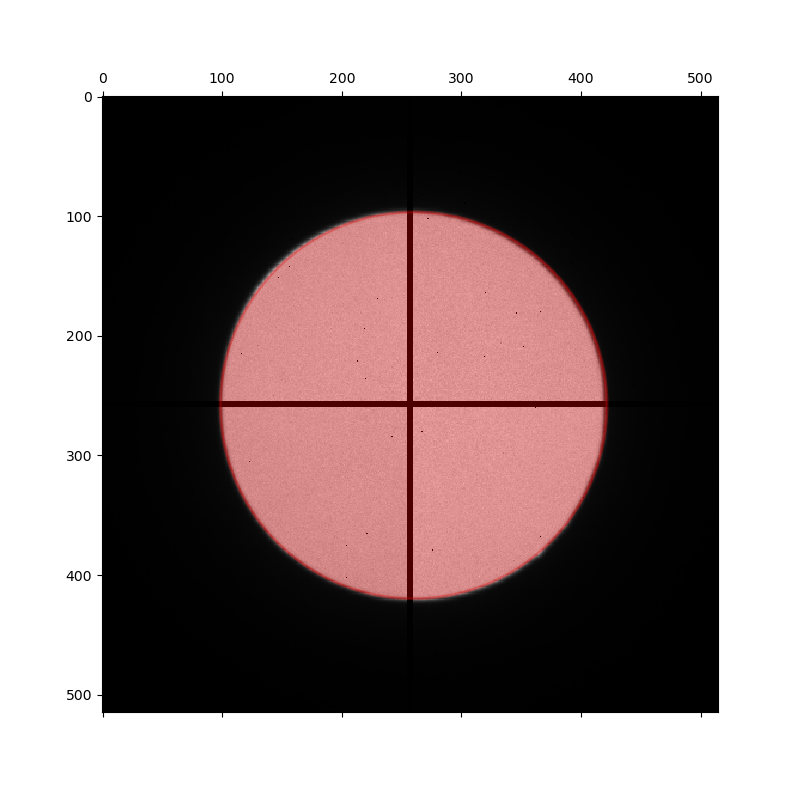

Estimated probe radius = 161.75 pixels


In [ ]:
# Estimate the radius of the BF disk, and the center coordinates
v_min = float(global_thresholds.split(',')[0])
v_max = float(global_thresholds.split(',')[1])
probe_semiangle, qx0, qy0 = py4DSTEM.process.calibration.get_probe_size(d_mean.data, v_min,v_max)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
py4DSTEM.visualize.show_circles(d_mean.data, (qx0, qy0), probe_semiangle)

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

In [ ]:
plt.savefig(f'{os.getcwd()}/detceted_BF_disc_radius_{int(probe_semiangle)}_pix.png')

<IPython.core.display.Javascript object>


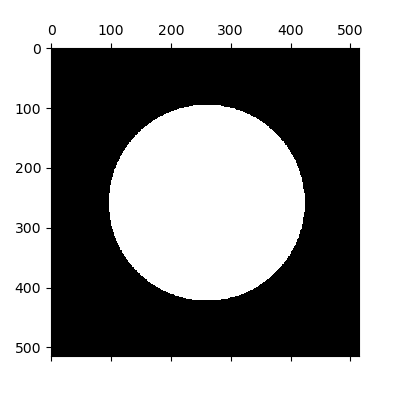

In [ ]:
# Generate the circular mask, using the same coordinates determined above.
expand_BF = 2.0

dataset = py4DSTEM.io.DataCube(data = d_mask.data)

mask = py4DSTEM.process.utils.make_circular_mask(shape = (dataset.Q_Nx,dataset.Q_Ny),
                                               qxy0 = (qx0, qy0),
                                               radius = probe_semiangle + expand_BF)
    
# Plot the mask
py4DSTEM.visualize.show(mask, figsize=(4,4))

In [ ]:
# Calculate the center of mass for all probe positions
CoMx, CoMy = py4DSTEM.process.dpc.get_CoM_images(dataset, mask=mask)

<IPython.core.display.Javascript object>


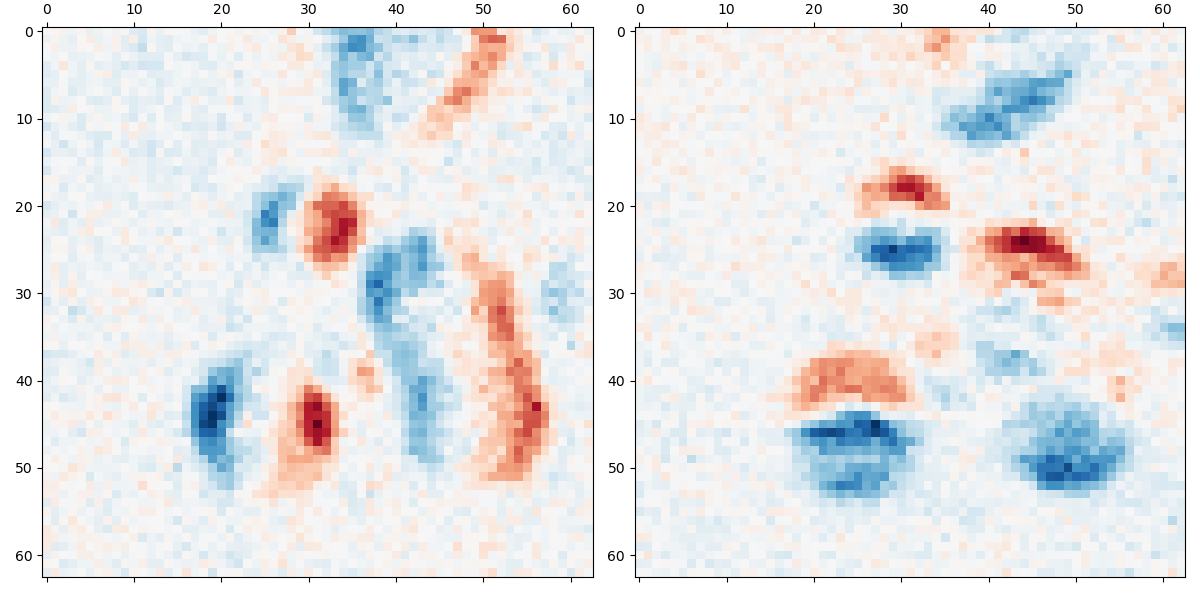

In [ ]:
# Plot the 2 CoM outputs, the x and y directions
py4DSTEM.visualize.show_image_grid(
    lambda i:[CoMx, CoMy][i],
    H=1,
    W=2,
    cmap='RdBu')

In [ ]:
plt.savefig(f'{os.getcwd()}/CoM_x_y.png')

In [ ]:
# Use one of the py4DSTEM algorithms to check for:
# 1 - rotation offset between real and diffraction space coordinates
# 2 - a flip / transpose of the two spaces
#theta, flip =  py4DSTEM.process.dpc.get_rotation_and_flip_maxcontrast(CoMx, CoMy, 360)
d_shape = d.data.shape
theta, flip =  py4DSTEM.process.dpc.get_rotation_and_flip_zerocurl(CoMx, CoMy, d_shape[0], d_shape[1])
print(theta, flip)

1.4953712302026012 False


In [ ]:
# Solve for minimum rotation from (-pi,pi) radian range
theta = np.mod(theta + np.pi, 2*np.pi) - np.pi
theta_deg = theta*180/np.pi

# Print the results
print('Image flip detected =', flip);
print('Best fit rotation = ', '%.4f' % theta_deg, 'degrees')

Image flip detected = False
Best fit rotation =  85.6785 degrees


<IPython.core.display.Javascript object>


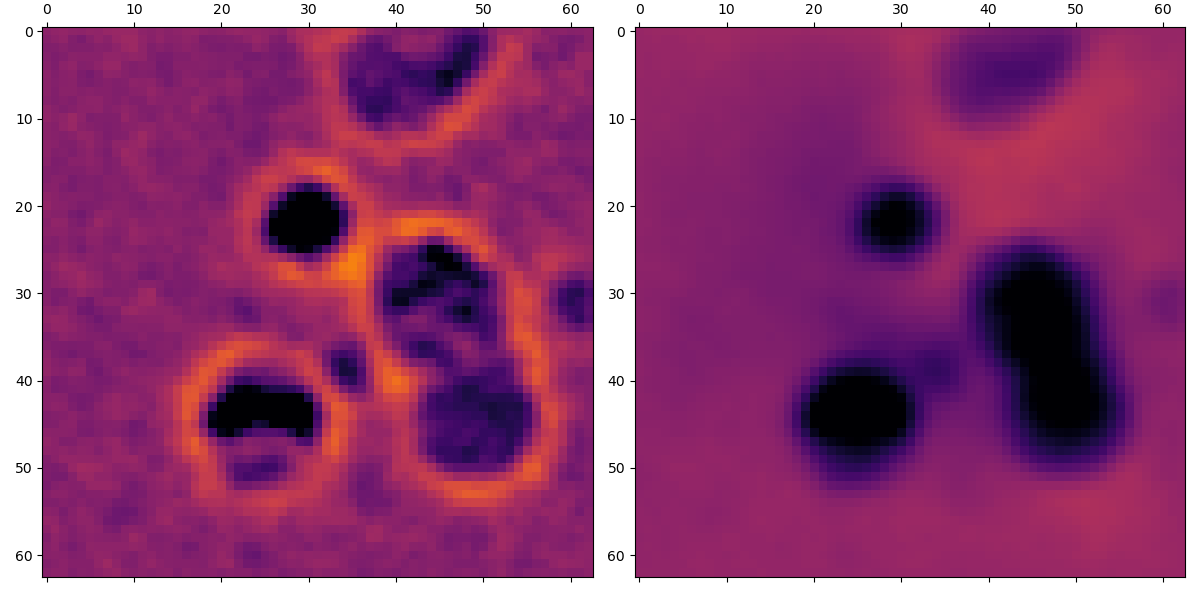

/dls_sw/apps/python/miniforge/4.10.0-0/envs/epsic3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [ ]:
# Input parameters
regLowPass = 0.0
regHighPass = 0.0
theta_recon = theta  # We get the same reconstruction with 0 rotation - try it!
flip_recon = flip   # We just set this to True
paddingfactor = 2    # This parameter handles the boundary conditions via padding the reconstruction space
stepsize = 1         # Step size for each iteration
n_iter = 8         # Number of iterations

# Reconstruct the phase
phase, error = py4DSTEM.process.dpc.get_phase_from_CoM(
    CoMx, 
    CoMy, 
    theta=theta_recon, 
    flip=flip,
    regLowPass=regLowPass, 
    regHighPass=regHighPass, 
    paddingfactor=paddingfactor,
    stepsize=stepsize, 
    n_iter=n_iter)


# Plot the output phase image
# py4DSTEM.visualize.show(phase,
#                        cmap='inferno')

# Input parameters with regularization
regLowPass = 0
regHighPass = 0.005
# Reconstruct the phase
phase_reg, error_ref = py4DSTEM.process.dpc.get_phase_from_CoM(
    CoMx, 
    CoMy, 
    theta=theta_recon, 
    flip=flip_recon,
    regLowPass=regLowPass, 
    regHighPass=regHighPass, 
    paddingfactor=paddingfactor,
    stepsize=stepsize, 
    n_iter=n_iter)

py4DSTEM.visualize.show_image_grid(
    lambda i:[phase_reg, phase][i],
    H=1,
    W=2,
    clipvals='std',
    min=-3,
    max=5,
    cmap='inferno')

In [ ]:
plt.savefig(f'{os.getcwd()}/phase_from_CoM.png')

<IPython.core.display.Javascript object>


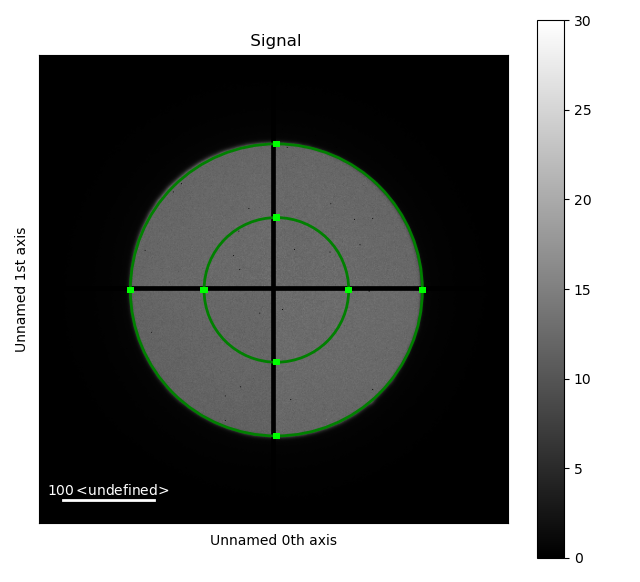

In [ ]:
# Compute ABF
# import gc
# del d
# gc.collect()
probe_semiangle, qx0, qy0
min_ang = int(probe_semiangle / 2) # in pix
max_ang = int(probe_semiangle) # in pix


d_mean.plot(vmax=30)
d_T = d_mask.T

# defining the detector
abf_det = hs.roi.CircleROI(cx=int(qy0), cy=int(qx0), 
                           r=max_ang, 
                           r_inner=min_ang)
abf_sig = abf_det.interactive(d_T, navigation_signal=d_mean)
fig = plt.gcf()
fig.savefig(f'{os.getcwd()}/ABF_detector.png')

In [ ]:
abf_sig = abf_sig.data.astype('uint16')
abf_sig[np.isnan(abf_sig)] = 0
abf_sig = hs.signals.Signal2D(abf_sig) #.as_lazy()
# abf_sig.compute()
abf_im = abf_sig.sum()
abf_im = 255 * abf_im.data / np.max(abf_im.data)
abf_im = hs.signals.Signal2D(abf_im)

<IPython.core.display.Javascript object>


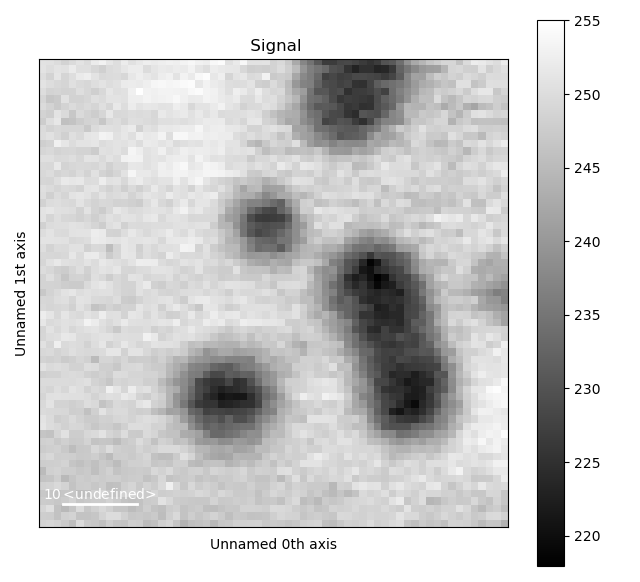

In [ ]:
abf_im.plot()

In [ ]:
plt.savefig(f'{os.getcwd()}/AbF_im.png')